## Visualization

In [ ]:
from visualization import process_stpt_image, process_imc_image

import matplotlib.pyplot as plt
from torchvision import transforms
import torch

### Plot a sample of STPT and IMC image

In [8]:
stpt = process_stpt_image('../data/STPT/S001_Z00.tif').permute(2,0,1)

imc = process_imc_image('../data/IMC/SECTION_01/143Nd_Vimentin.tif')
stpt = transforms.Resize(imc.shape[0])(stpt).permute(1,2,0)

In [9]:
imc = imc[16:18704, 16:18704]
print(stpt.shape)
print(imc.shape)

torch.Size([18720, 18720, 4])
torch.Size([18688, 18688])


In [ ]:
f, (axarr1, axarr2) = plt.subplots(1,2, figsize=(14,6))
axarr1.axis("off")
axarr2.axis("off")
axarr1.set_title('STPT', pad=20)
axarr2.set_title('IMC', pad=20)
axarr1.imshow(stpt.numpy(), cmap='gray')
axarr2.imshow(imc.numpy(), cmap='gray')

f.savefig('../figures/sample_imc_stpt.png')

### Plot chunk

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


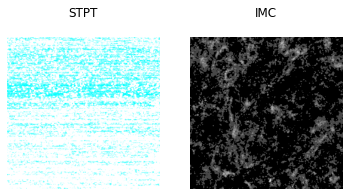

In [10]:
phys_sec = '10'   # choose which physical section to reconstruct
chunk = '40_22'  # choose which chunk to extract

# load images
stpt_piece = torch.load('processed_data/STPT/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))

imc_piece = torch.load('processed_data/IMC/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))

f, (axarr1, axarr2) = plt.subplots(1,2)
axarr1.axis("off")
axarr2.axis("off")
axarr1.set_title('STPT', pad=20)
axarr2.set_title('IMC', pad=20)
axarr1.imshow(stpt_piece[:4].permute(1,2,0).numpy(), cmap='gray')
axarr2.imshow(imc_piece.permute(1,2,0)[:,:,5].numpy(), cmap='gray')

# f.savefig('../figures/sample_imc_stpt_crop.png')

### Plot loss curve

In [2]:
from visualization import display_img
from skimage import io, exposure
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import torch

In [6]:
unet_output = open('../checkpoints/unet_output.txt')
contents = unet_output.read()
lines = contents.splitlines()

In [7]:
import re

losses = []
for line in lines[1:]:
    try:
        found = re.search('\tLoss (.+?) ', line).group(1)
        losses.append(float(found))
    except AttributeError:
        pass

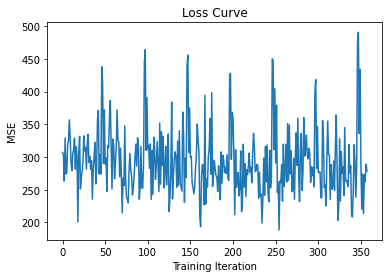

In [10]:
plt.plot(losses)
plt.locator_params(axis='y', nbins=10)
plt.title('Loss Curve')
plt.xlabel('Training Iteration')
plt.ylabel('MSE')
plt.savefig('../figures/unet_loss_curve.png')

## Compare reconstruction to target IMC images

In [2]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
import cv2 as cv
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
from torch.multiprocessing import Pool, set_start_method
# For utilities
import os, shutil, time

from img_processing import process_stpt_image, process_imc_image
from models import UNet

/home/kevin/miniconda3/envs/dl/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
model = UNet().double()

checkpoint = torch.load('checkpoints/model-epoch-26-losses-23.318.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
phys_sec = '10'   # choose which physical section to reconstruct
chunk = '40_22'  # choose which chunk to extract

# load images
stpt_piece = torch.load('processed_data/STPT/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))
imc_reconst = model(stpt_piece.unsqueeze(0)).squeeze()

imc_true = torch.load('processed_data/IMC/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))

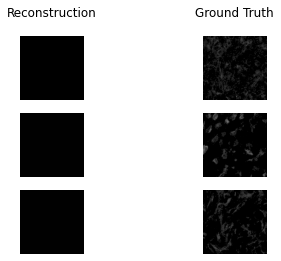

In [7]:
# plot sample and target pairs

nrows = 3
ncols = 2
f, axarr = plt.subplots(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        axarr[i, j].axis("off")
        
chs = [5, 15, 35]
axarr[0, 0].set_title('Reconstruction', pad=20)
axarr[0, 1].set_title('Ground Truth', pad=20)
axarr[0, 0].imshow(imc_reconst[chs[0]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[0, 1].imshow(imc_true[chs[0]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[1, 0].imshow(imc_reconst[chs[1]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[1, 1].imshow(imc_true[chs[1]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[2, 0].imshow(imc_reconst[chs[2]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[2, 1].imshow(imc_true[chs[2]].detach().numpy(), cmap='gray', vmin=0, vmax=255)

In [31]:
# save figure with file name corresponding to physical section and chunk

f.savefig('../figures/{0}_{1}.png'.format(phys_sec, chunk))